# Run a NF Experiment, II

In [1]:
import time
import matplotlib
import sys
import scipy
import numpy as np
import easygui
import matplotlib.pyplot as plt
import mne
from IPython.display import clear_output
import re
import pickle
import dynarray

import logging  # set log level
logging.basicConfig(level=logging.WARNING)

sys.path.append("../../mushu")  # driver for the amps
sys.path.append("../../mushu/libmushu")
import libmushu

sys.path.append("../../nftools")  # handy stuff needed for NF
from nftools.loopcontrol import LoopState
from nftools.analysis import convert_alld_allm_to_mne
from nftools.analysis import select_part_from_mne_dataset
from nftools.analysis import plot_compare_two_spectra
from nftools import camera

sys.path.append("../../wyrm")  # real-time data analysis
from wyrm.types import RingBuffer
from wyrm.types import BlockBuffer
from wyrm import io

sys.path.append('/home/nfcontrol/nf/nf-rtime/callpyff/')

In [2]:
import libmushu
amp = libmushu.get_amp('bpamp')

In [3]:
# Configure the amp
amp.configure(remotecontrol=True,
              recorderip='20.100.0.3',
              recorderport=51244,
              pathtoworkspace='C:\\Vision\\Workfiles\\NF_64chEEG.rwksp',
              experimentnumber='Pre-Run01',
              subjectid='0001',
              n_channels=64,
              fs=5000)

connecting to 20.100.0.3 port 6700
sending b'1C:\\Vision\\Workfiles\\NF_64chEEG.rwksp'
sending b'2Pre-Run01'
sending b'30001'
sending b'4'
sending b'M'


In [ ]:
from callpyff import bcinetwork, bcixml

In [ ]:
bcinet = bcinetwork.BciNetwork('20.100.0.2', bcinetwork.FC_PORT, bcinetwork.GUI_PORT, 'bcixml')

In [ ]:
feedbacks = bcinet.getAvailableFeedbacks()
print(feedbacks)

In [ ]:
bcinet.send_init('EEGfMRILocalizer')
bcinet.get_variables()

In [ ]:
# camera
c=camera.DoCamera(); c.start()

In [ ]:
bcinet.play()

In [4]:
amp.start()

Number of channels: 64
Sampling interval: 200.0
Resolutions: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Channel Names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
hdr SamplingInterval = 200.00


In [5]:
alld=dynarray.DynamicArray((None, len(amp.get_channels())))     # data
allm=[]     # markers
sfreq = 5000 # amp.get_sampling_frequency()  # sampling frequency
ch_names=['ch %d' % i for i in range(64)] # amp.get_channels()  # channel names

markTime=time.time()
updateTime = 0.1  # run some kind of calculation every X seconds
buffSize = 1.0  # run calculation on last X seconds of data


rb = RingBuffer(buffSize * 5000) # aw_fromfile.info['sfreq'])  # the buffer containing the last X seconds of data
# totalTime = seed_d.shape[0]/raw_fromfile.info['sfreq']

In [6]:
l=LoopState(); l.start()
markeroffset = 0  # needed to store all data in one big mat/vector
t0=time.time()
curTime=time.time()

while l.get_state() != 'Stop':
   
    
    # keep track of time:
    curTime = time.time()

    
    # this is where you get the data
    data, marker, annotations = amp.get_data()
    cnt = io.convert_mushu_data(data, marker, sfreq, ch_names)
    newsamples = cnt.data.shape[0]

    
    rb.append(cnt)
    
    
    
    # do the following every 0.1 msec:
    if curTime - markTime > updateTime:
        # do Stuff
        
        markTime = curTime
        # 1) obtain last 1-second(s)
        d = rb.get()
        
        # thomas does stuff here
        feature = d.data.mean() - 200. / 10.
        
        # we send the value to BCI/STIM
        bcinet.send_signal(bcixml.BciSignal({'NFSignalContainer': [feature]},None, bcixml.INTERACTION_SIGNAL))
        
        
        clear_output(wait=True)  # write some logging information here
        print('Playing... time = %f' % (curTime - t0))
        print('Length Markers: %d' % len(allm))
        print('Feature: %f' % feature)
        print(data.shape)

        

        
    
    # append it to the big matrix
    alld.extend(data)
    for m in marker:
        allm.append([m[0] + markeroffset, m[1]])
    markeroffset += newsamples / float(sfreq) * 1000.

Playing... time = 58.124333
Length Markers: 0
Feature: -208.003692
(100, 64)
loop is stopped!


In [7]:
amp.stop()

amplifier stopped!


In [8]:
ch_names=amp.get_channels()
alld.shrink_to_fit()

In [9]:
# write to disk, so we can re-load it later:

t={'alld':alld, 'allm':allm, 'ch_names':ch_names, 'sfreq':sfreq}
with open('c-allm-and-alld.pkl', 'wb') as f:
    pickle.dump(t, f)

In [ ]:
# load from disk:

with open('c-allm-and-alld.pkl','rb') as f:
    t=pickle.load(f)
for key in t.keys():
    locals()[key] = t[key]

In [10]:
alld.shape

(311800, 64)

In [11]:
raw = convert_alld_allm_to_mne(alld, allm, ch_names, sfreq)  # covert to MNE
raw.set_eeg_reference(ref_channels='average')

The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.


../../nftools/nftools/analysis.py:30: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.
  montage=montage


Creating RawArray with float64 data, n_channels=64, n_times=311800
    Range : 0 ... 311799 =      0.000 ...    62.360 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=311800
    Range : 0 ... 311799 =      0.000 ...    62.360 secs
Ready.
Applying average reference.
Applying a custom EEG reference.


<RawArray  |  None, n_channels x n_times : 65 x 311800 (62.4 sec), ~154.8 MB, data loaded>

In [12]:
% matplotlib qt5

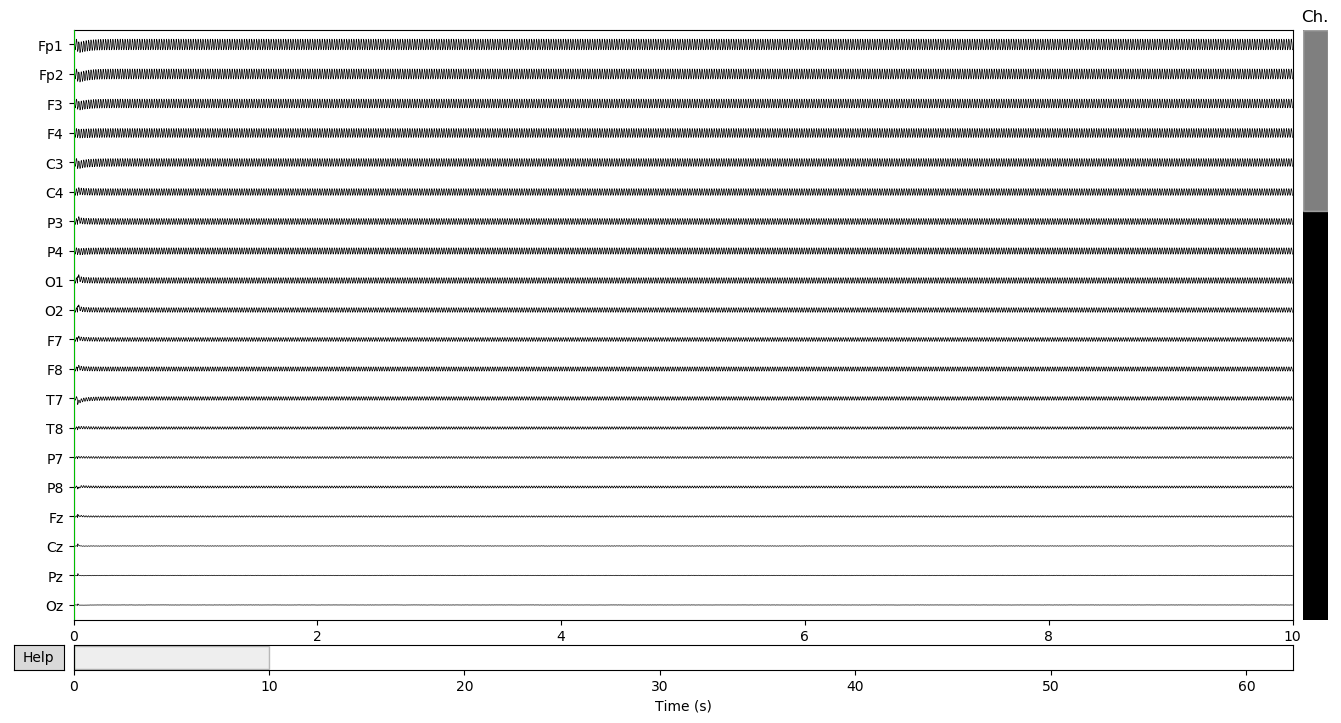

In [13]:
raw.plot(scalings='auto')